In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn import metrics as skmetrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize, quantile_transform, QuantileTransformer
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical

from skopt.utils import use_named_args
import logging

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_parquet("./dataset.parquet")\
    .dropna(subset=['month_purchase'])

In [4]:
df.loc[:, 'has_second_sale_same_day'] = (
    (df.loc[:, 'has_second_sale_within_year'] == 1) & 
    (df.loc[:, 'waiting_time'] == 0)
)

categorical_columns = ['partner', 'device', 'gender', 'state', 'channel']
feature_columns = [
    'channel', 'partner', 'device', 'age', 'gender', 'state', 'has_marketplace', 
    'has_crossdocking', 'has_private_label', 'has_brands', 'gmv', 'fst_sale_in_black_friday_days'
]

In [5]:
df.has_second_sale_same_day.value_counts()

False    311390
True     125065
Name: has_second_sale_same_day, dtype: int64

In [6]:
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [7]:
features = [c for c in df.columns if any([c.startswith(x) for x in feature_columns])]
X = df.loc[:, features]
y = df.loc[:, 'has_second_sale_same_day'].astype(int)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
qt = QuantileTransformer()
qt.fit(X_train.loc[:, ["age", "gmv"]])

X_train.loc[:, ["age", "gmv"]] = qt.transform(X_train.loc[:, ["age", "gmv"]])
X_test.loc[:, ["age", "gmv"]] = qt.transform(X_test.loc[:, ["age", "gmv"]])

/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
HYPERPARAMETER_SPACE = [
    Integer(1, 10, name='min_child_weight'),
    Real(1e-5, 1.0, "uniform", name='learning_rate'),
    Real(0.1, 10, "log-uniform", name='gamma'),    
    Real(0.05, 1, name='subsample'),
    Real(0.05, 1, name='colsample_bytree'),
    Integer(2, 10, name='max_depth'),
    Integer(2, 200, name="n_estimators"),
    Real(0.01, 0.99, name="base_score"),
    Real(0, 500, name="scale_pos_weight"),
    Real(0, 5, name="reg_alpha"),
    Real(0, 5, name="reg_lambda"),
]

HYPERPARAMETER_NAMES = [dim.name for dim in HYPERPARAMETER_SPACE]

In [11]:
RANDOM_STATE = 939568576
TREE_METHOD = 'exact'
NUM_PROCESSORS = 4
NUM_CROSS_VALIDATION_STEPS = 1
NUM_GP_OPTIMIZATION_STEPS = 1

In [12]:
def get_logger(name):
    logger = logging.getLogger(name)
    formatter = logging.Formatter('[%(levelname)s] %(asctime)s: %(name)s - %(message)s')
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)
    return logger

In [13]:
def train_model(X, y, **kwargs):
    model = XGBClassifier(
        random_state=RANDOM_STATE,
        tree_method=TREE_METHOD,
        n_jobs=NUM_PROCESSORS,
        **kwargs,
    )
    model.fit(X, y)
    return model

def evaluate_model(X, y, **kwargs):
    roc_auc = []
    for _ in range(NUM_CROSS_VALIDATION_STEPS):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
        model = train_model(X_train, y_train, **kwargs)
        score = model.predict_proba(X_test)[:, 1]
        roc_auc.append(skmetrics.roc_auc_score(y_test, score))
    return np.mean(roc_auc)


def train_optimized_model(X, y):
    
    logger = get_logger(__name__)
    
    @use_named_args(HYPERPARAMETER_SPACE)
    def loss(**kwargs):
        return -evaluate_model(X, y, **kwargs)

    def get_optimization_callback():
        message = "Hyperparameter optimization iteration {:d}/{:d}. Current: {:5.3f}. Best: {:5.3f}. Parameters:\n{}"
        def callback(res):          
            current_value = -res.func_vals[-1]
            best_value = -res.func_vals.min()            
            current_params = pd.Series(dict(zip(
                HYPERPARAMETER_NAMES, 
                map(fix_type, res.x)
            )))
            logger.info(message.format(
                len(res.func_vals),
                NUM_GP_OPTIMIZATION_STEPS,
                current_value,
                best_value,
                current_params
            ))

        return callback

    def fix_type(x):
        if isinstance(x, bool):
            return x
        elif np.issubdtype(np.dtype(x), np.int_):
            return int(x)
        elif np.issubdtype(np.dtype(x), np.float_):
            return float(x)

    logger.info("Will start hyperparameter optimization.")
    optimization_results = gp_minimize(
        loss,
        HYPERPARAMETER_SPACE,
        n_random_starts=max(1, min(10, int(NUM_GP_OPTIMIZATION_STEPS / 2))),
        n_calls=NUM_GP_OPTIMIZATION_STEPS,
        random_state=RANDOM_STATE,
        callback=get_optimization_callback(),
    )
    logger.info("Finished hyperparameter optimization.")
    best_parameters = dict(
        zip(HYPERPARAMETER_NAMES, map(fix_type, optimization_results.x))
    )
    logger.info("Starting training of final model.")
    return train_model(X, y, verbosity=1, **best_parameters)


In [14]:
%time best_model = train_optimized_model(X_train, y_train)

[INFO] 2019-04-17 21:10:18,027: __main__ - Will start hyperparameter optimization.
[INFO] 2019-04-17 21:10:29,667: __main__ - Hyperparameter optimization iteration 1/1. Current: 0.890. Best: 0.890. Parameters:
min_child_weight     3.000000
learning_rate        0.316840
gamma                1.260333
subsample            0.784180
colsample_bytree     0.268833
max_depth            6.000000
n_estimators        84.000000
base_score           0.613412
scale_pos_weight     5.992884
reg_alpha            4.715997
reg_lambda           1.309442
dtype: float64
[INFO] 2019-04-17 21:10:29,668: __main__ - Finished hyperparameter optimization.
[INFO] 2019-04-17 21:10:29,669: __main__ - Starting training of final model.


CPU times: user 1min 33s, sys: 772 ms, total: 1min 33s
Wall time: 24.4 s


In [15]:
y_pred = best_model.predict(X_test)
print(skmetrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81     93488
           1       0.55      0.84      0.66     37449

   micro avg       0.76      0.76      0.76    130937
   macro avg       0.73      0.78      0.74    130937
weighted avg       0.81      0.76      0.77    130937



In [16]:
s_pred = best_model.predict_proba(X_test)[:, 1]

In [17]:
skmetrics.roc_auc_score(y_test, s_pred)

0.8865136159025325

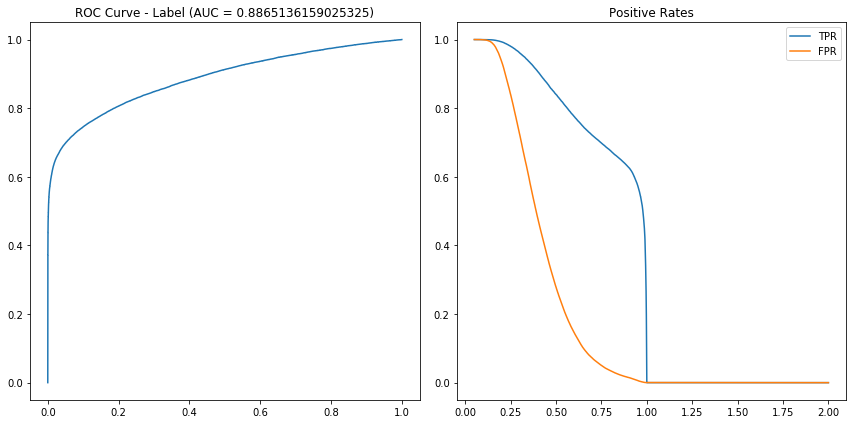

In [18]:
fig = plt.figure(figsize=(12, 6))

roc_auc = skmetrics.roc_auc_score(y_test, s_pred)
fpr, tpr, roc_thres = skmetrics.roc_curve(y_test, s_pred)

ax = fig.add_subplot(1, 2, 1)
ax.set_title(f"ROC Curve - Label (AUC = {roc_auc})")
ax.plot(fpr, tpr)

ax = fig.add_subplot(1, 2, 2)
ax.set_title(f"Positive Rates")
ax.plot(roc_thres, tpr, label="TPR")
ax.plot(roc_thres, fpr, label="FPR")
ax.legend()

fig.tight_layout()

In [19]:
n_points = 100

thresholds = np.linspace(s_pred.min(), s_pred.max()*0.999, n_points)

metrics = pd.DataFrame([
    np.array(skmetrics.precision_recall_fscore_support(y_test, (s_pred >= threshold), average=None))[:, 0]
    for threshold in thresholds
], columns=["precision", "recall", "f1", "support"], index=thresholds)

metrics.head()

/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


precision    recall        f1  support
0.050002   0.000000  0.000000  0.000000  93488.0
0.059588   1.000000  0.000021  0.000043  93488.0
0.069173   1.000000  0.000032  0.000064  93488.0
0.078759   1.000000  0.000160  0.000321  93488.0
0.088344   0.882353  0.000321  0.000642  93488.0

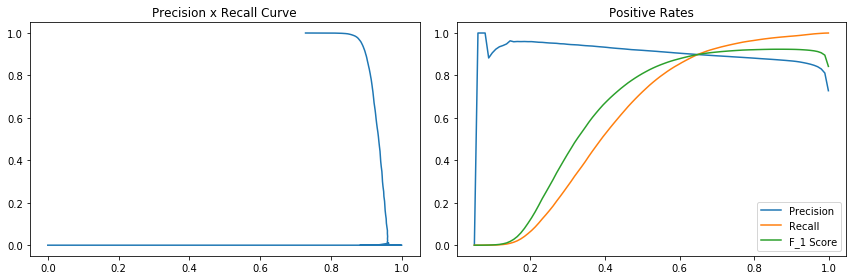

In [20]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121)
ax.set_title("Precision x Recall Curve")
ax.plot(metrics.precision, metrics.recall)

ax = fig.add_subplot(122)
ax.set_title("Positive Rates")
ax.plot(metrics.index, metrics.precision, label="Precision")
ax.plot(metrics.index, metrics.recall, label="Recall")
ax.plot(metrics.index, metrics.f1, label="F_1 Score")
ax.legend()

fig.tight_layout()

In [21]:
optimal_threshold = metrics.f1.argmax()
print(metrics.loc[optimal_threshold])
y_pred = (s_pred > optimal_threshold).astype(int)

precision        0.873514
recall           0.979602
f1               0.923521
support      93488.000000
Name: 0.8647765833651176, dtype: float64


/home/calsaverini/.local/share/virtualenvs/survival-Ls_z5C1J/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  """Entry point for launching an IPython kernel.


In [22]:
print(skmetrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     93488
           1       0.93      0.65      0.76     37449

   micro avg       0.88      0.88      0.88    130937
   macro avg       0.90      0.81      0.84    130937
weighted avg       0.89      0.88      0.88    130937



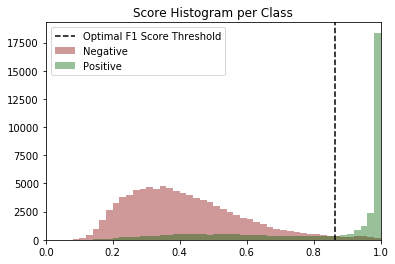

In [23]:
fig, ax = plt.subplots(figsize=(6, 4))
bins = np.linspace(0, 1, 51)
sns.distplot(s_pred[y_test == 0], bins=bins, label="Negative", ax=ax, color="DarkRed", kde=False)
sns.distplot(s_pred[y_test == 1], bins=bins, label="Positive", ax=ax, color="DarkGreen", kde=False)
ax.axvline(optimal_threshold, color='k', ls='--', label="Optimal F1 Score Threshold")
ax.set_title("Score Histogram per Class")
ax.set_xlim(0, 1.0)
ax.legend()

In [24]:
import shap

In [25]:
shap.initjs()

In [26]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

In [27]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

In [32]:
sample = X_test.sample(1000).index

In [33]:
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)

In [34]:
shap.force_plot(
    explainer.expected_value, 
    shap_values_df.loc[sample, :].values, 
    X_test.loc[sample, :],
    link="logit"
)

In [35]:
shape_diffs = shap_values_df.groupby(y_test).mean().diff().dropna().T[1]
feat_import = pd.Series(dict(zip(X_test.columns, best_model.feature_importances_))).sort_values(ascending=False)

Text(0.5, 1.0, 'Tree Feature Importance')

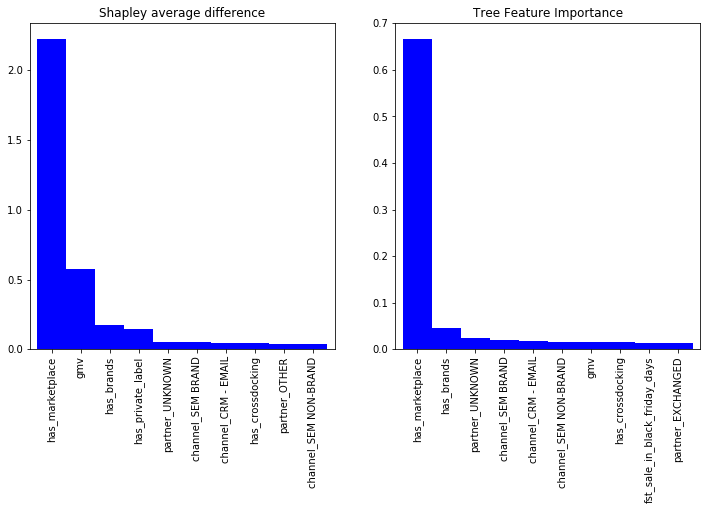

In [36]:
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121)
shape_diffs.sort_values(ascending=False).head(10).plot.bar(color='blue', width=1, ax=ax)
ax.set_title("Shapley average difference")
ax = fig.add_subplot(122)
feat_import.sort_values(ascending=False).head(10).plot.bar(color='blue', width=1, ax=ax)
ax.set_title("Tree Feature Importance")

In [37]:
qX_test = pd.DataFrame(quantile_transform(X_test), columns=X_test.columns, index=X_test.index)

In [38]:
y_test.name = "foo"

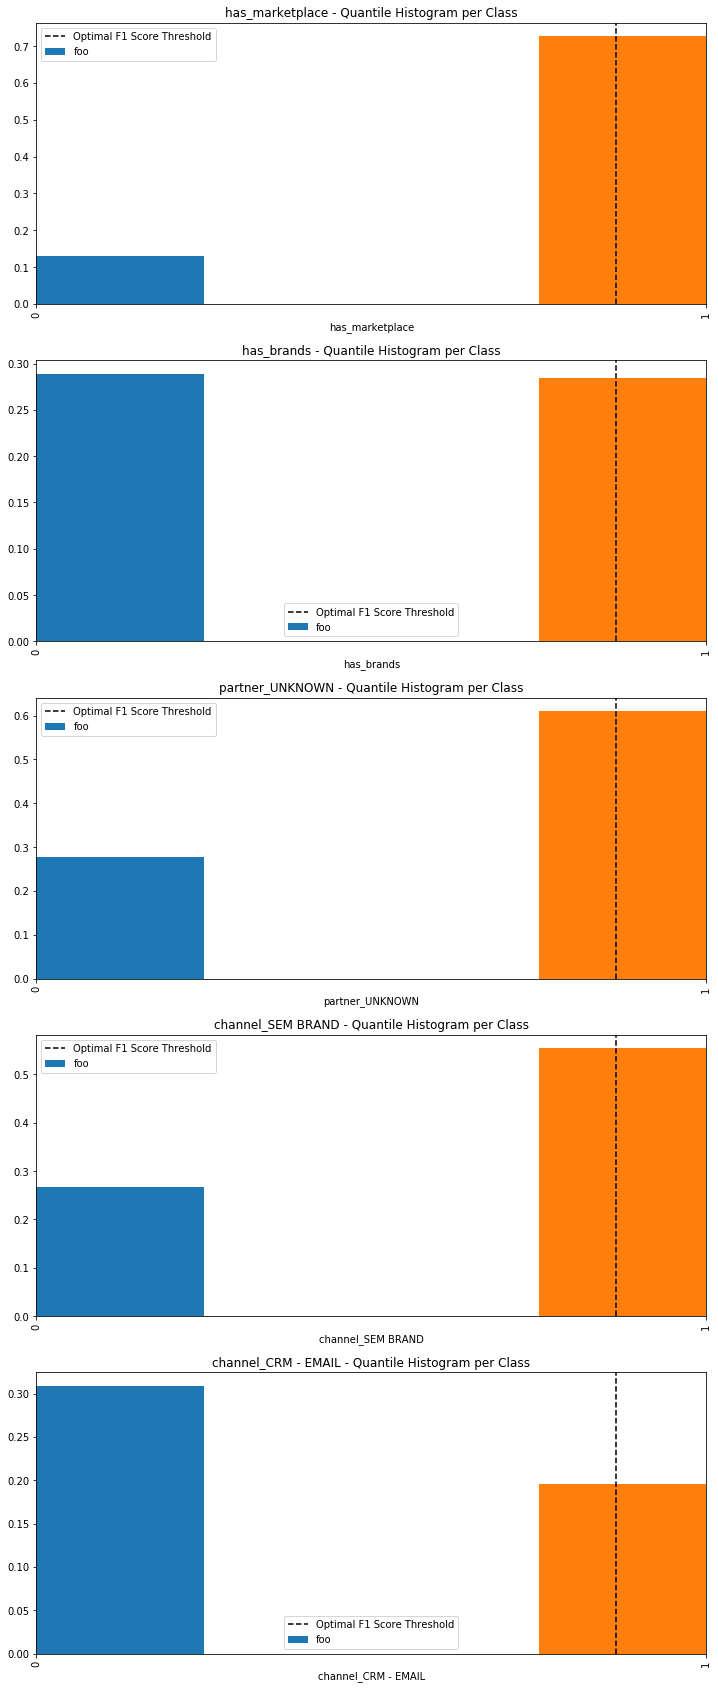

In [44]:
fig = plt.figure(figsize=(12, 5 * 6))
bins = np.linspace(0, 1, 51)
for k, feature in enumerate(feat_import.sort_values(ascending=False).head(5).index):
    ax = fig.add_subplot(5, 1, k + 1)
    if X_test.loc[:, feature].nunique() > 2:
        sns.distplot(qX_test.loc[y_test == 0, feature], bins=bins, label="Negative", ax=ax, color="DarkRed", kde=False)
        sns.distplot(qX_test.loc[y_test == 1, feature], bins=bins, label="Positive", ax=ax, color="DarkGreen", kde=False)
    else:
        y_test.groupby(X_test.loc[:, feature]).mean().plot.bar(ax=ax)
    ax.axvline(optimal_threshold, color='k', ls='--', label="Optimal F1 Score Threshold")
    ax.set_title(f"{feature} - Quantile Histogram per Class")
    ax.set_xlim(0, 1.0)
    ax.legend()